In [1]:
import torch
import torch.nn as nn
from torch.autograd.variable import Variable
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataUtils.CustomDataset as CastomDataset
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
workers = 20
btch_sz = 32
num_epochs = 30
lr = 0.02
beta1 = 0.5
ngpu = 1

In [3]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training data

240 (1365, 2048, 3) [0 0 1 0]
241 (1365, 2048, 3) [0 0 1 0]
242 (1365, 2048, 3) [0 0 0 1]
243 (1365, 2048, 3) [0 0 0 1]
244 (1365, 2048, 3) [0 0 1 0]
245 (2048, 1365, 3) [0 1 0 0]
246 (1365, 2048, 3) [1 0 0 0]
247 (1365, 2048, 3) [1 0 0 0]
248 (1365, 2048, 3) [1 0 0 0]
249 (1365, 2048, 3) [1 0 0 0]
250 (1365, 2048, 3) [0 0 0 1]
251 (1365, 2048, 3) [0 0 0 1]


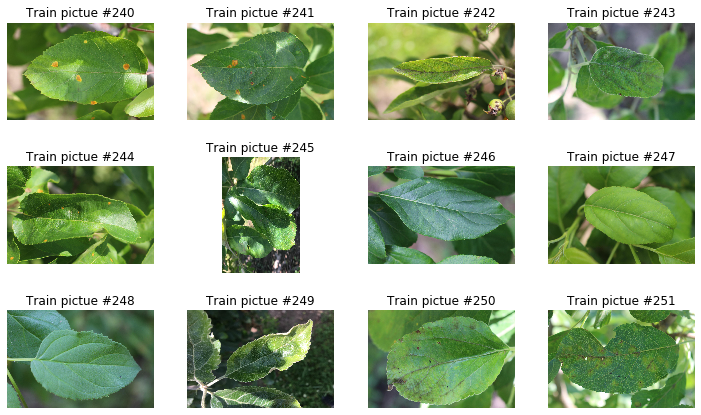

In [4]:
plant_dataset = CastomDataset.PlantPathologyDataset('train.csv', 'images/train')

plt.figure(figsize=(10,10))
for i in range(240,252):
    sample = plant_dataset[i]
    print(i, sample['image'].shape, sample['labels'])
    
    ax = plt.subplot(5, 4, i-239)
    plt.tight_layout()
    ax.set_title('Train pictue #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
   

In [5]:
df = pd.read_csv('train.csv')
validation = df[1790:]
train = df[:1780]
validation.to_csv('validation.csv', index=False)
train.to_csv('train_new.csv')

In [7]:
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Format dataloader

In [27]:
plant_dataset = CastomDataset.PlantPathologyDataset('train_new.csv',
                                                    'images/train',
                                                    transform=CastomDataset.ToTensor()
                                                   )

plant_dataset_valid = CastomDataset.PlantPathologyDataset('validation.csv',
                                                    'images/valid',
                                                    transform=CastomDataset.ToTensor()
                                                   )

plant_dataset_test = CastomDataset.PlantPathologyDataset('test.csv',
                                                    'images/test',
                                                    transform=CastomDataset.ToTensor(),
                                                    data_type='test'
                                                   )

dataloader = DataLoader(plant_dataset, batch_size=btch_sz,
                        shuffle=True, num_workers=workers,
                        )

dataloader_valid = DataLoader(plant_dataset_valid, batch_size=btch_sz,
                        shuffle=True, num_workers=workers,
                        )

dataloader_test = DataLoader(plant_dataset_test, batch_size=5,
                        shuffle=False, num_workers=workers,
                        )

In [9]:
batch = next(iter(dataloader_test))
batch['image'].shape

torch.Size([5, 3, 224, 224])

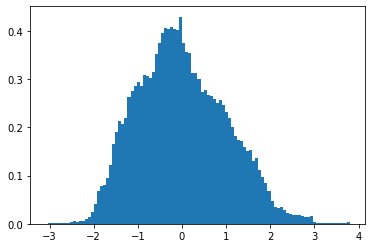

In [10]:
plt.hist(batch['image'].view(-1), bins=100, normed=True)
plt.show()

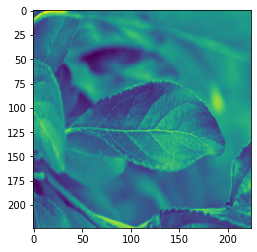

In [11]:
plt.imshow(batch['image'][0].sum(dim=0))
plt.show()
# print(batch['labels'][0])

In [12]:
image = plant_dataset[245]['image']
image.shape

torch.Size([3, 224, 224])

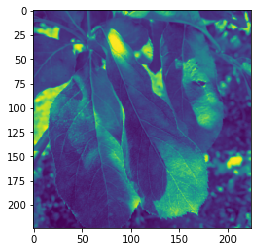

In [13]:
plt.imshow(image.sum(dim=0))
plt.show()

# Load VGG network

In [11]:
from torchvision import models
from torch import nn
from torch import optim

model = models.vgg16_bn(pretrained = True)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 1000),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1000, 100),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(100, 4)
                                )
model = model.to(device)

In [12]:
sum(p.numel() for p in model.parameters())

121685184

In [27]:
output = model(batch['image'][:2].to(device))
output.shape, batch['image'][:2].shape

(torch.Size([2, 4]), torch.Size([2, 3, 224, 224]))

In [28]:
output

tensor([[ 0.0752,  0.0330,  0.0605,  0.0177],
        [-0.0118,  0.1063,  0.1034, -0.0590]], device='cuda:0',
       grad_fn=<AddmmBackward>)

# Optimirez and criterion loss

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
train_losses = np.array([])
valid_losses = np.array([])
train_accurasy = np.array([])
valid_accurasy = np.array([])

# Training loop

In [17]:
valid_batch = next(iter(dataloader_valid))

In [18]:
valid_images = valid_batch['image'].to(device)
valid_labels = valid_batch['labels'].to(device)

In [19]:
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [56]:
num_epochs = 10
for epoch in range(num_epochs):

    running_loss = 0.0
    running__valid_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        
        images, labels = batch['image'], batch['labels']
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
  
        loss = criterion(output, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        model.eval()
        predicted_idx = torch.max(output, 1)[1]
        true_idx = torch.max(labels, 1)[1]
        accuracy = sum(true_idx == predicted_idx).item()/len(true_idx)
        train_accurasy = np.append(train_accurasy, accuracy)
        
        
        valid_output = model(valid_images)
        valid_loss = criterion(valid_output, torch.max(valid_labels, 1)[1])
        
        predicted_idx = torch.max(valid_output, 1)[1]
        true_idx = torch.max(valid_labels, 1)[1]
        accuracy = sum(true_idx == predicted_idx).item()/len(true_idx)
        valid_accurasy = np.append(valid_accurasy, accuracy)
        
        
        running_loss += loss.item()
        running__valid_loss += valid_loss.item()
        
        
        if i%10 == 9:
            train_losses = np.append(train_losses, running_loss)
            valid_losses = np.append(valid_losses, running__valid_loss)
            print('[{}/{}] [{}/{}], loss: {}, validation loss: {}'.format(epoch,
                                                     num_epochs,
                                                     i*btch_sz,
                                                     btch_sz*len(dataloader),
                                                     round(running_loss/10, 4),
                                                     round(running__valid_loss/10, 4)                                                     
                                                    )
                 )
            running_loss = 0.0
            running__valid_loss = 0.0

[0/10] [288/1792], loss: 0.0338, validation loss: 2.0903
[0/10] [608/1792], loss: 0.0305, validation loss: 0.4284
[0/10] [928/1792], loss: 0.0007, validation loss: 0.377
[0/10] [1248/1792], loss: 0.0663, validation loss: 0.5668
[0/10] [1568/1792], loss: 0.0358, validation loss: 0.2611
[1/10] [288/1792], loss: 0.0064, validation loss: 0.3425
[1/10] [608/1792], loss: 0.0028, validation loss: 0.307
[1/10] [928/1792], loss: 0.0061, validation loss: 0.3246
[1/10] [1248/1792], loss: 0.0001, validation loss: 0.4003
[1/10] [1568/1792], loss: 0.0864, validation loss: 0.4411
[2/10] [288/1792], loss: 0.0133, validation loss: 0.752
[2/10] [608/1792], loss: 0.0691, validation loss: 1.8425
[2/10] [928/1792], loss: 0.0643, validation loss: 1.4901
[2/10] [1248/1792], loss: 0.0567, validation loss: 2.1394
[2/10] [1568/1792], loss: 0.173, validation loss: 0.9022
[3/10] [288/1792], loss: 0.068, validation loss: 1.5131
[3/10] [608/1792], loss: 0.0314, validation loss: 0.6015
[3/10] [928/1792], loss: 0.000

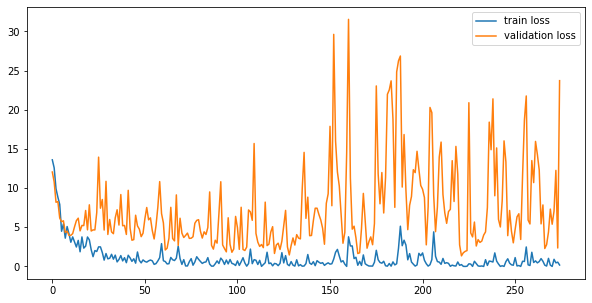

In [57]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

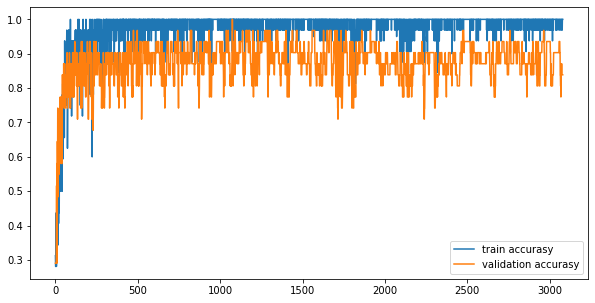

In [58]:
plt.figure(figsize=(10,5))
plt.plot(train_accurasy, label='train accurasy')
plt.plot(valid_accurasy, label='validation accurasy')
plt.legend()
plt.show()

# Prediction


In [44]:
model.eval()
accuracy = 0
prediction = torch.tensor([]).to(device)
for i, batch in enumerate(dataloader_test):
    
    images = batch['image']
    images = images.to(device)
    
    with torch.no_grad():
        output = model(images)
  
    
    predicted_idx = torch.max(output, 1)[1]
    prediction = torch.cat((prediction, output), 0)

    print(predicted_idx[:5])

tensor([2, 2, 3, 0, 2], device='cuda:0')
tensor([0, 0, 3, 3, 2], device='cuda:0')
tensor([0, 0, 3, 0, 2], device='cuda:0')
tensor([0, 0, 3, 3, 2], device='cuda:0')
tensor([3, 0, 2, 3, 3], device='cuda:0')
tensor([3, 3, 2, 0, 2], device='cuda:0')
tensor([0, 3, 0, 3, 3], device='cuda:0')
tensor([3, 2, 3, 3, 2], device='cuda:0')
tensor([2, 2, 3, 2, 0], device='cuda:0')
tensor([3, 0, 2, 2, 2], device='cuda:0')
tensor([2, 2, 2, 2, 2], device='cuda:0')
tensor([3, 3, 0, 3, 2], device='cuda:0')
tensor([3, 0, 3, 3, 3], device='cuda:0')
tensor([2, 0, 2, 3, 2], device='cuda:0')
tensor([3, 2, 3, 0, 3], device='cuda:0')
tensor([3, 0, 2, 3, 3], device='cuda:0')
tensor([2, 2, 2, 2, 3], device='cuda:0')
tensor([3, 2, 0, 3, 3], device='cuda:0')
tensor([2, 0, 0, 2, 3], device='cuda:0')
tensor([0, 3, 0, 0, 3], device='cuda:0')
tensor([3, 0, 3, 3, 3], device='cuda:0')
tensor([3, 0, 2, 3, 2], device='cuda:0')
tensor([0, 0, 2, 3, 2], device='cuda:0')
tensor([2, 2, 2, 2, 0], device='cuda:0')
tensor([2, 2, 2,

tensor([2, 0, 2, 3, 3], device='cuda:0')
tensor([0, 2, 3, 0, 2], device='cuda:0')
tensor([2, 2, 3, 2, 3], device='cuda:0')
tensor([0, 2, 2, 3, 2], device='cuda:0')
tensor([2, 2, 2, 0, 0], device='cuda:0')
tensor([3, 0, 3, 0, 0], device='cuda:0')
tensor([0, 3, 3, 2, 2], device='cuda:0')
tensor([2, 0, 0, 3, 3], device='cuda:0')
tensor([3, 3, 0, 2, 3], device='cuda:0')
tensor([2, 0, 0, 3, 3], device='cuda:0')
tensor([2, 3, 3, 2, 0], device='cuda:0')
tensor([3, 2, 3, 0, 3], device='cuda:0')
tensor([3, 0, 0, 2, 3], device='cuda:0')
tensor([0, 3, 3, 3, 2], device='cuda:0')
tensor([0, 2, 3, 3, 2], device='cuda:0')
tensor([2, 3, 0, 3, 2], device='cuda:0')
tensor([0, 2, 3, 0, 2], device='cuda:0')
tensor([3, 2, 3, 2, 3], device='cuda:0')
tensor([3, 0, 0, 3, 0], device='cuda:0')
tensor([3, 3, 0, 3, 3], device='cuda:0')
tensor([2, 0, 2, 3, 3], device='cuda:0')
tensor([3, 0, 2, 0, 0], device='cuda:0')
tensor([2, 2, 0, 2, 2], device='cuda:0')
tensor([2, 2, 0, 2, 3], device='cuda:0')
tensor([2, 2, 3,

In [45]:
output.shape

torch.Size([1, 4])

In [46]:
softmax = nn.Softmax()
predict_soft = softmax(prediction)

In [47]:
predict_soft

tensor([[1.5070e-33, 1.4596e-36, 1.0000e+00, 2.2186e-38],
        [2.6521e-08, 7.6353e-09, 1.0000e+00, 4.3147e-06],
        [7.0968e-27, 7.4990e-26, 3.2661e-40, 1.0000e+00],
        ...,
        [1.0890e-08, 2.0092e-07, 1.0000e+00, 2.1979e-08],
        [1.0000e+00, 3.0244e-29, 2.5811e-26, 1.0284e-15],
        [1.8948e-03, 2.7027e-06, 1.3741e-07, 9.9810e-01]], device='cuda:0')

In [48]:
predict_soft = predict_soft.cpu().detach().numpy()

In [49]:
np.save('prediction', predict_soft)

In [45]:
predict_soft.shape

(1821, 4)

In [53]:
softmax(prediction)

tensor([[1.0221e-04, 6.2345e-03, 9.9350e-01, 1.6772e-04],
        [1.0221e-04, 6.2345e-03, 9.9350e-01, 1.6772e-04],
        [1.0221e-04, 6.2345e-03, 9.9350e-01, 1.6772e-04],
        ...,
        [1.0221e-04, 6.2345e-03, 9.9350e-01, 1.6772e-04],
        [1.0221e-04, 6.2345e-03, 9.9350e-01, 1.6772e-04],
        [1.0221e-04, 6.2345e-03, 9.9350e-01, 1.6772e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)